In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import os
import glob
import random

import warnings
warnings.filterwarnings("ignore")

data_path = '/content/drive/MyDrive/SolarGen/data/'

In [3]:
df_train = pd.read_csv(data_path + 'train/train.csv')
submission = pd.read_csv(data_path + 'sample_submission.csv')

### Preprocessing data through 2 steps

---



1. Detect outliers in DHI, DNI by LOF.  
Detected outliers are replaced by results of linear interpolation.

2. Apply appropriate scaler.

In [4]:
"""
Outlier detection using LOF.
"""
from sklearn.neighbors import LocalOutlierFactor
import scipy.interpolate as interpolate

def LOF(data, neighbors = 20 ,conta =0.01):
    """
    Get anomaly scores of data using LOF.
    used params: neighbors = 20, contamination = 0.005, p = 2
    """
    temp = data.copy()
    temp = temp[['DHI', 'DNI']]
    clf = LocalOutlierFactor(n_neighbors = neighbors, contamination = conta , p = 2) 
    y_pred = clf.fit_predict(temp)

    return y_pred

train_after_LOF = pd.DataFrame(LOF(df_train, 20, 0.005))
outlier_idx = train_after_LOF[train_after_LOF[0] < 1].index
outlier_idx

Int64Index([   17,    32,   124,   222,   606,   739,   786,   787,   788,
             1122,
            ...
            50944, 51474, 51476, 51524, 51665, 51725, 51726, 51857, 52049,
            52061],
           dtype='int64', length=263)

In [5]:
"""
Handling outliers.
1. Drop outliers
2. Fill them using linear interpolation.
"""
df_train.drop(outlier_idx, axis=0, inplace=True)
new_idx = [i for i in range(0,52560)]
added_idx_train = df_train.reindex(new_idx)
df_train = added_idx_train.interpolate(method = 'linear',limit_direction='forward')
df_train

,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET
0,0.0,0.0,0.0,0.0,0.0,1.5,69.08,-12.0,0.0
1,0.0,0.0,30.0,0.0,0.0,1.5,69.06,-12.0,0.0
2,0.0,1.0,0.0,0.0,0.0,1.6,71.78,-12.0,0.0
3,0.0,1.0,30.0,0.0,0.0,1.6,71.75,-12.0,0.0
4,0.0,2.0,0.0,0.0,0.0,1.6,75.20,-12.0,0.0
...,...,...,...,...,...,...,...,...,...
52555,1094.0,21.0,30.0,0.0,0.0,2.4,70.70,-4.0,0.0
52556,1094.0,22.0,0.0,0.0,0.0,2.4,66.79,-4.0,0.0
52557,1094.0,22.0,30.0,0.0,0.0,2.2,66.78,-4.0,0.0
52558,1094.0,23.0,0.0,0.0,0.0,2.1,67.72,-4.0,0.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f086a0eea20>,
      dtype=object)

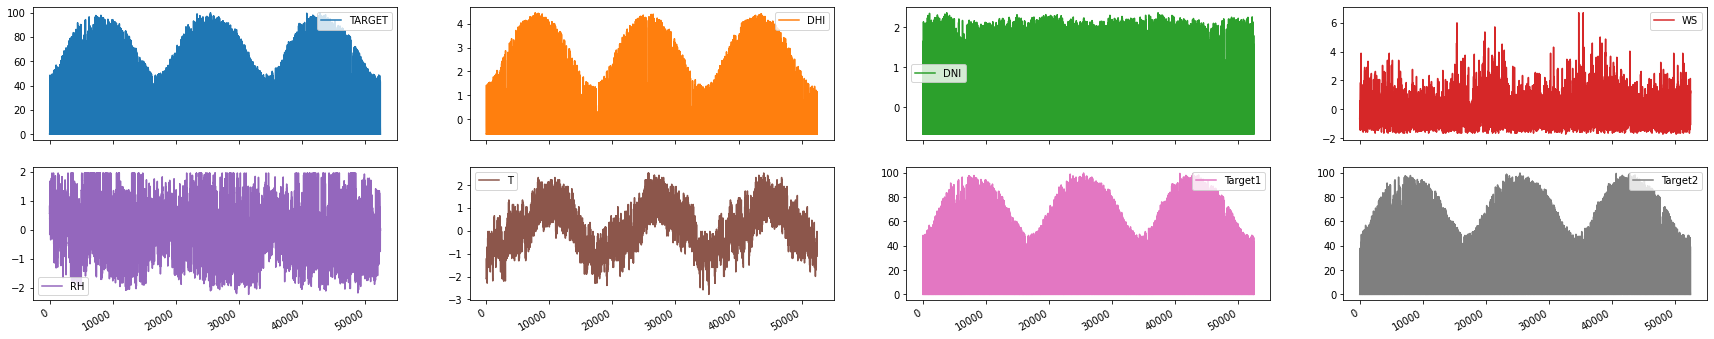

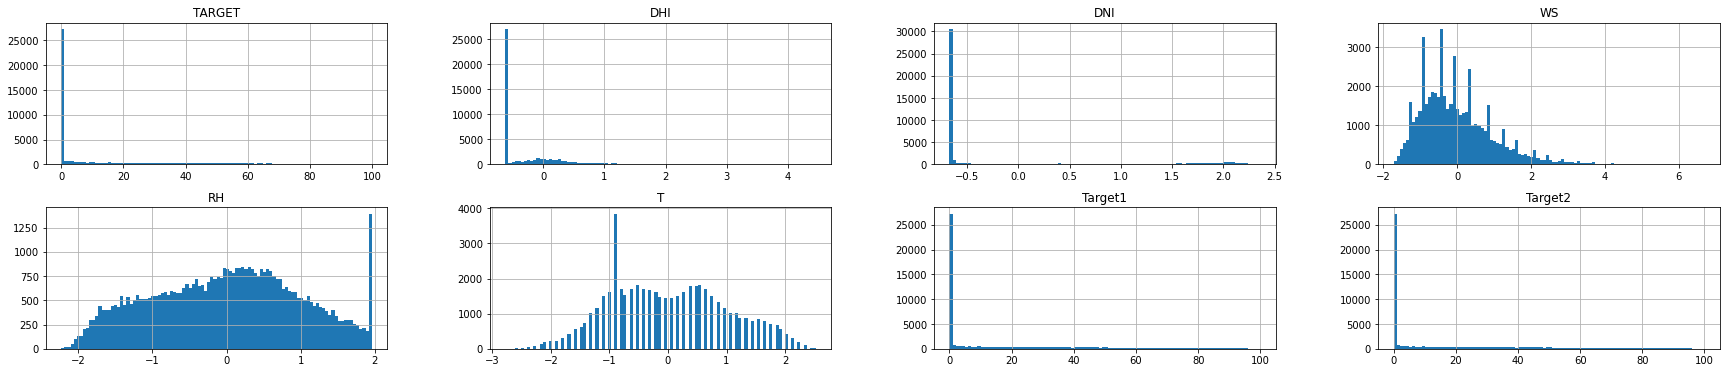

In [6]:
"""
Apply scaler to target features.
"""
import matplotlib.pyplot as plt
from sklearn.preprocessing import (
    MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer, 
    MaxAbsScaler, PowerTransformer
)

class ScalingFactor:
    """
    Class for saving factors related with scaler.
    Args:
        scaler: Scaler to use
        features: Target features to apply scaler
    """
    def __init__(self, scaler, features):
        self.scaler = scaler
        self.features = features

def scaling(data, scaler, features, is_train=True):
    """
    Apply scaler to target features
    """
    temp = data.copy()

    target_cols = features
    temp = temp[target_cols]
    if is_train: 
        scaler.fit(temp)
    scaled = scaler.transform(temp)

    data[target_cols] = scaled

    return data   

def preprocess_data(data, scale_factors, is_train=True):
    """
    Apply scaler and reconstruct dataframe with new targets for next 1 or 2 day.
    """
    
    temp = data.copy()

    for factor in scale_factors:
        temp = scaling(temp, factor.scaler, factor.features, is_train)

    temp = temp[['Hour', 'TARGET', 'DHI', 'DNI', 'WS', 'RH', 'T']]

    if is_train==True:          
    
        temp['Target1'] = temp['TARGET'].shift(-48).fillna(method='ffill')
        temp['Target2'] = temp['TARGET'].shift(-48*2).fillna(method='ffill')
        temp = temp.dropna()
        
        return temp.iloc[:-96]

    elif is_train==False:
                              
        return temp.iloc[-48:, :]

scale_factors = []
scale_factors.append(ScalingFactor(StandardScaler(), ['DHI', 'DNI', 'WS', 'RH', 'T']))
train = preprocess_data(df_train, scale_factors)

train.iloc[:, 1:].plot(subplots=True, layout=(2,4), figsize=(30,6))
train.iloc[:, 1:].hist(bins = 100, layout=(2,4), figsize=(30,6))

In [7]:
test = []

for i in range(81):
    file_path = data_path + 'test/' + str(i) + '.csv'
    temp = pd.read_csv(file_path)
    temp = preprocess_data(temp, scale_factors, is_train=False)
    test.append(temp)

X_test = pd.concat(test)
X_test.shape

(3888, 7)

In [8]:
# Split data into train and validation set
from sklearn.model_selection import train_test_split
X_train_1, X_valid_1, Y_train_1, Y_valid_1 = train_test_split(train.iloc[:, :-2], train.iloc[:, -2], test_size = 0.2, random_state=0)
X_train_2, X_valid_2, Y_train_2, Y_valid_2 = train_test_split(train.iloc[:, :-2], train.iloc[:, -1], test_size = 0.2, random_state=0)

### Modeling and Prediction

---

For quantile regression, modeling GBM model and use it to prediction.  

Used model is optimized by score function.

In [9]:
quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

In [10]:
"""
Create model using GBM
"""
from sklearn.ensemble import GradientBoostingRegressor

def GBM(q, X_train, Y_train):
    
   mod = GradientBoostingRegressor(random_state=1, alpha=q, loss='quantile', verbose=1, max_features = 'auto',
                                n_estimators=2000, max_depth=20, learning_rate=0.03)
   mod.fit(X_train, Y_train)

   return mod

def train_data(X_train, Y_train, X_test):

    GBM_models=[]
    GBM_actual_pred = pd.DataFrame()

    for q in quantiles:
        model = GBM(q, X_train, Y_train)
        GBM_models.append(model)
        pred = pd.Series(model.predict(X_test).round(2))
        GBM_actual_pred = pd.concat([GBM_actual_pred,pred],axis=1)

    GBM_actual_pred.columns=quantiles

    return GBM_models, GBM_actual_pred

In [11]:
# Estimate predictions' Scores from validation set to optimize the model's performance.
def Scores(GBM_models, X_valid, Y_valid):
    score_record = []
    for i in range(0,9):
        score_record.append(GBM_models[i].score(X_valid, Y_valid))
        print("[%.1f]"%quantiles[i] + "\t%f"%score_record[i])
    print("[avg]\t%.6f"%np.average(score_record))

In [12]:
GBM_models_1, results_1 = train_data(X_train_1, Y_train_1, X_test)
Scores(GBM_models_1,X_valid_1, Y_valid_1)

      Iter       Train Loss   Remaining Time 
         1           1.7710            4.98m
         2           1.7564            5.13m
         3           1.7396            5.62m
         4           1.7215            6.19m
         5           1.7040            6.65m
         6           1.6878            7.08m
         7           1.6704            7.39m
         8           1.6536            7.70m
         9           1.6372            8.00m
        10           1.6202            8.31m
        20           1.4650            9.92m
        30           1.3408           10.96m
        40           1.2481           11.44m
        50           1.1753           11.77m
        60           1.1125           12.08m
        70           1.0553           12.27m
        80           1.0073           12.41m
        90           0.9567           12.51m
       100           0.9178           12.67m
       200           0.6791           12.80m
       300           0.5501           12.32m
       40

In [13]:
GBM_models_2, results_2 = train_data(X_train_2, Y_train_2, X_test)
Scores(GBM_models_2,X_valid_2, Y_valid_2)

      Iter       Train Loss   Remaining Time 
         1           1.7693            5.05m
         2           1.7565            5.51m
         3           1.7414            6.07m
         4           1.7258            6.61m
         5           1.7101            6.96m
         6           1.6943            7.46m
         7           1.6788            7.98m
         8           1.6636            8.33m
         9           1.6480            8.71m
        10           1.6318            9.00m
        20           1.4869           10.82m
        30           1.3662           11.89m
        40           1.2709           12.43m
        50           1.1899           12.85m
        60           1.1229           13.01m
        70           1.0750           13.11m
        80           1.0241           13.21m
        90           0.9798           13.28m
       100           0.9521           13.28m
       200           0.7402           12.85m
       300           0.6199           12.36m
       40

In [14]:
# Handling negative values by replacing them with zero
results_1 = results_1.clip(0.0)
results_2 = results_2.clip(0.0)

In [15]:
submission.loc[submission.id.str.contains("Day7"), "q_0.1":] = results_1.values
submission.loc[submission.id.str.contains("Day8"), "q_0.1":] = results_2.values
submission

,id,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
0,0.csv_Day7_0h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.csv_Day7_0h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.csv_Day7_1h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.csv_Day7_1h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.csv_Day7_2h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
7771,80.csv_Day8_21h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7772,80.csv_Day8_22h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7773,80.csv_Day8_22h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7774,80.csv_Day8_23h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
submission.to_csv(data_path + 'submission.csv', index=False)